# Bayesian factor model
Includes bias and noise.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal, StudentT

from plot_utils import * # see plot_utils.py

import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')

import bijectors as bijector

In [4]:
ledermann_bound = lambda p: (2*p+1-(8*p+1)**.5)*.5

In [10]:
x_train = np.zeros((999, 20))

In [13]:
#x_train[:333,:] = np.array([0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1])
#x_train[333:666,:] = np.array([1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1])
#x_train[666:,:] = np.array([1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0])
x_train[:500,:10] = 1
x_train[500:,10:] = 1

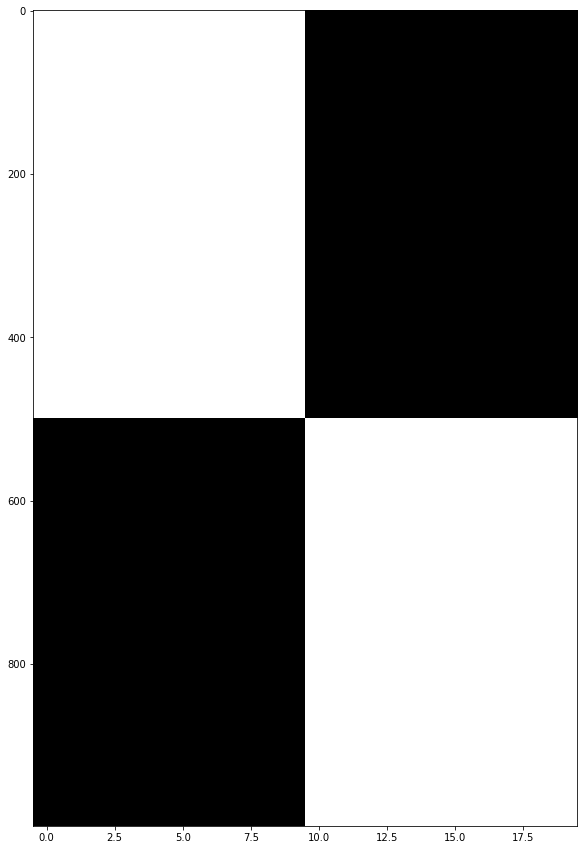

In [14]:
plt.imshow(x_train,cmap='gray',aspect=.03)
plt.rcParams['figure.figsize'] = (15,15)

In [15]:
N, D = x_train.shape

In [16]:
ledermann_bound(D) # if this is > K, model should be identifiable according to Identifiability of Factor Analysis: Some Results and Open Problems

14.155711229775239

In [17]:
from tensorflow.python.client import device_lib

In [18]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11654688570593219706]

## P-model

\begin{align}
i \in {1,...,D}\\
j \in {1,...,K}\\
n \in {1,...,N}\\
\tau &\sim StudentT(1,0)\\
\lambda_j &\sim StudentT(1,0)\\
w_{ij}&\sim N(0,|\tau||\lambda_j|)\\
z_{jn}&\sim N(0,1)\\
\mu_i &\sim N(0,1)\\
\sigma_i &\sim Gamma(1,1)\\
x_i&\sim \prod\mathrm{Cat}(\mathcal{S}(W\cdot z)_i+\mu_i,\sigma_i)\\
\end{align}

### The automatic relevance determination in higher dimensions

The ARD might seem like an overkill but it comes in handy in higher dimensions, where the dimensionality of the latent space is not a prior known.  Let us generate a higher dimensional data set and see how ARD determines the latent dimensionality.

In [48]:
class low_rank_categorical_horseshoe_ard():
    def __init__(self,M,D,C):
        # Fit as many latent variables as dimensions, prune by ACD
        #K=D
        K=2
        #########
        # halfCauchy = StudentT(df=1., loc=0., scale=1.)
        # Horseshoe! Happy now, Aki? Hyva!
        #########
        # P-model
        #sigma = ed.models.Gamma(tf.ones([D]),tf.ones([D]))
        tau = StudentT(df=1., loc=tf.zeros([C]), scale=tf.ones([C])*.01, name="tau")
        lamda = StudentT(df=1., loc=tf.zeros([C,K]), scale=tf.ones([C,K]), name="lambda")
        w = Normal(tf.zeros([C, D, K]),    tf.reshape(tf.tile(tf.transpose(tf.reshape(tf.tile(np.abs(tau),[K]),[K,C]))*np.abs(lamda),[1,D]),[C,D,K]), name="W")
            # a factor loading matrix for every variable 
        z = Normal(tf.zeros([M, K]),    tf.ones([M, K])*10, name="z")
        mu = Normal(tf.zeros([C,D]),       tf.ones([C,D]), name="mu")
            # an offset for every variable 
        x = ed.models.Categorical(tf.nn.softmax(tf.add(tf.transpose(tf.matmul(w,tf.reshape(tf.tile(z,[C,1]),[C,M,K]),transpose_b=True)),tf.transpose(mu))), name="x")

#        self.Pmodel = (sigma,lamda,tau,w,z,mu)
        self.Pmodel = (lamda,tau,w,z,mu) # not sure if observation noise is relevant for categorical data, ask Lars
        self.x = x
        #########
        # Q-model
        qtau = ed.models.TransformedDistribution(
        distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.random_normal([C])),
                                                       tf.Variable(tf.random_normal([C]))),
        bijector=bijector.Exp(),
        name="qtau")
        
        qlamda = ed.models.TransformedDistribution(
        distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros([C,K])),
                                                       tf.Variable(tf.zeros([C,K]))),
        bijector=bijector.Exp(),
        name="qlamda")
        qw = Normal(tf.Variable(tf.random_normal([C, D, K])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([C, D, K]))), name="qW")
        qz = Normal(tf.Variable(tf.random_normal([M, K])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([M, K]))), name="qz")

        # assume standardized data
        qmu = Normal(tf.Variable(tf.random_normal([C,D])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([C,D]))), name="qmu")
        #qsigma = ed.models.TransformedDistribution(
        #    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros(D)),
        #                                  tf.Variable(tf.ones(D))),
        #    bijector=bijector.Exp(),
        #    name="qsigma")

        #self.Qmodel = (qsigma,qlamda,qtau,qw,qz,qmu)
        self.Qmodel = (qlamda,qtau,qw,qz,qmu)
        
    def initialize(self, x_train):
        '''
        Initialize parameters of Q-model in the solution from PCA, and empirical means and standard deviations, for faster convergence.
        '''
        #K=D
        K=2
        N = x_train.shape[0]
        qsigma,qlamda,qtau,qw,qz,qmu = self.Qmodel
        # set qmu mean to data mean
        data_mean = np.mean(x_train,axis=0).astype(np.float32,copy=False)
        qmu = Normal(tf.Variable(data_mean+tf.random_normal([D])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
        # set qsigma mean to data stds
        data_std = np.std(x_train,axis=0).astype(np.float32,copy=False)
        qsigma = ed.models.TransformedDistribution(
            distribution=ed.models.NormalWithSoftplusScale(tf.Variable(np.log(data_std)),
                                          tf.Variable(tf.ones(D)*3)),
            bijector=bijector.Exp(),
            name="qsigma")
        # set qw mean to ppca solution (see 12.61 in Murphy)
        _,S,V = np.linalg.svd(x_train-x_train.mean(0))
        qw = Normal(tf.Variable(np.dot(V,np.diag(S))/np.sqrt(N-1)),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
        self.Qmodel = (qsigma,qlamda,qtau,qw,qz,qmu)

    def infer(self, x_train, n_epoch = 100, n_print=100, n_samples=100, M = 100, optimizer = 'rmsprop', learning_rate=0.01, momentum=0.0):
        # add mini-batches
        def generator(arrays, batch_size):
            # assuming arrays is a list of arrays of equal length, with rows being observations
            while True:
                batches = []
                random_idx = np.random.choice(arrays[0].shape[0], batch_size)
                for array in arrays:
                    batches.append(array[random_idx])
                yield batches
        x_ph = tf.placeholder(tf.int32, [None,D])
        data = generator([x_train], M)
        n_batch = int(N / M)
        # add progress bar
        x = self.x
        inference = ed.KLqp(dict(zip(self.Pmodel,self.Qmodel)), data={x: x_ph})
        if optimizer == 'rmsprop':
            optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0,momentum = momentum)
        else:
            optimizer = 'adam'
        inference.initialize(n_iter=n_batch * n_epoch, n_print=(n_batch * n_epoch)/10, n_samples=n_samples, optimizer=optimizer)

        sess = ed.get_session()
        init = tf.global_variables_initializer()
        init.run()

        # assert x_ph.shape[0] == M 
        learning_curve = []
        for _ in range(inference.n_iter):
            x_batch = next(data)[0]
            info_dict = inference.update({x_ph: x_batch})
            if _%inference.n_print == 0:
                print(info_dict)
            learning_curve.append(info_dict['loss'])
        plt.semilogy(learning_curve)
        plt.show()
    
    def prior_predictive_check(self):
        self.x_prior = ed.copy(self.x)
        pass
        
    def posterior_predictive_check(self, x_test):
        self.x_post = ed.copy(self.x, dict(zip(self.Pmodel,self.Qmodel)))
        return ed.evaluate('log_likelihood', data={self.x_post: x_test})
    
    def plot_histograms(self,n_hist=3000):
        for variable in meddle.Qmodel:
            plt.show()
            if all([i < 10 for i in variable.shape]):
                samples = variable.sample(n_hist).eval()
            else:
                samples = variable.sample().eval()
            if variable.shape == []:
                plt.hist(samples,'auto')
                plt.title(variable.name)
            else:
                for dimension in range(variable.shape[0]):
                    plt.hist(samples[:,dimension],'auto')
                    plt.title(variable.name)
                    
    def print_model(self):
        qsigma,qlamda,qtau,qw,qz,qmu = self.Qmodel
        # add pair plots
        print("Inferred principal axes (columns):")
        print(qw.mean().eval())
        print(qw.variance().eval())
        print("Inferred center:")
        print(qmu.mean().eval())
        print(qmu.variance().eval())

In [49]:
M = 100
meddle = low_rank_categorical_horseshoe_ard(M,D,C=2)
#meddle.initialize(x_train)

sess = ed.get_session()
model = meddle.x.get_ancestors()
model.append(meddle.x)
model_sample = dict(zip(model,sess.run([[v.value() for i in range(10)] for v in model])))

meddle.prior_predictive_check()

# sample all variables ancestrally
model = meddle.x_prior.get_ancestors()
model.append(meddle.x_prior)
model_sample = dict(zip(model,sess.run([v.value() for v in model])))

sess = ed.get_session()
tmp = meddle.x_prior.sample().eval().T
with sess.as_default():
    plt.scatter(*tmp)
    plt.scatter(*x_train[:,:M])
    plt.axis('equal')
    plt.show()

In [50]:
N

999

In [51]:
meddle.infer(x_train, M=M, n_epoch = 1000, n_samples = 70, optimizer='gradientdescent')#, learning_rate=0.0001,momentum=.1)
#meddle.infer(x_train, M=M, n_epoch = 1000, n_samples = 170, optimizer='rmsprop')#, learning_rate=0.0001,momentum=.1)
#meddle.infer(x_train, M=M, n_epoch = 2000, n_samples = 70, optimizer='adam')

InvalidArgumentError: Input 0 of node copied/copied/Tile_2 was passed double from Const_6284:0 incompatible with expected float.

In [ ]:
meddle.posterior_predictive_check(x_train[:M,:])

In [ ]:
foo = meddle.x_post.sample().eval()

In [ ]:
#mahz = np.zeros((M,D),dtype=np.float64)

In [ ]:
#mahz[:50,:] = -10.
#mahz[50:,:] = 10.

In [ ]:
#fuzz = ed.copy(meddle.x_post, {meddle.Qmodel[3]:mahz})

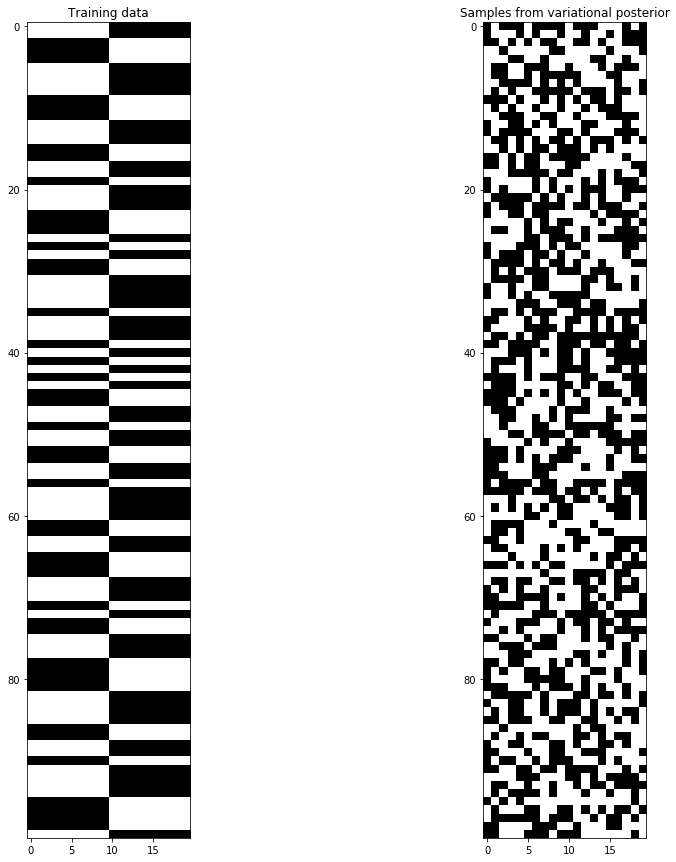

In [34]:
plt.subplot(121)
plt.imshow(x_train[np.random.choice(N,M),:],cmap='gray')
plt.title('Training data')
plt.subplot(122)
plt.imshow(foo,cmap='gray')
plt.title('Samples from variational posterior')
plt.rcParams['figure.figsize'] = (15,15)

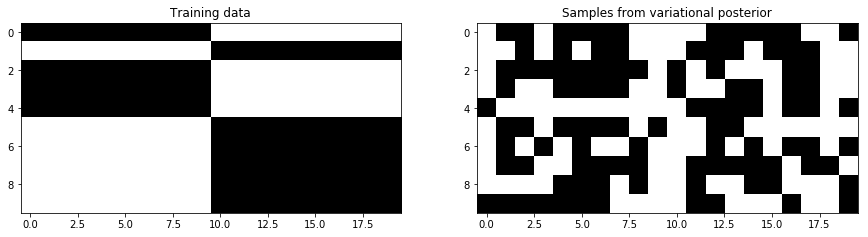

In [26]:
plt.subplot(121)
plt.imshow(x_train[np.random.choice(N,10),:],cmap='gray')
plt.title('Training data')
plt.subplot(122)
plt.imshow(foo[np.random.choice(M,10),:],cmap='gray')
plt.title('Samples from variational posterior')
plt.rcParams['figure.figsize'] = (15,15)

In [20]:
latent = meddle.Qmodel[3].mode().eval()

In [21]:
latent

array([[ 0.92890352,  3.49236894,  0.12938538, ..., -0.17947039,
         1.72386074, -0.14574805],
       [ 1.21843982,  3.09199524, -0.13808195, ..., -0.45061639,
         1.5251404 , -0.74422073],
       [ 1.22814584,  3.67762208,  0.19538033, ...,  0.81136054,
         1.5323894 , -0.17438659],
       ..., 
       [ 1.01232433,  2.31685305,  0.38356376, ...,  0.61254126,
         1.80064774, -0.10645571],
       [ 0.31273603,  2.89957356, -0.56312776, ...,  1.07672751,
         0.89555687, -0.38185379],
       [ 0.05255999,  3.07759595, -0.2388645 , ...,  0.30013075,
         1.66894698, -0.48424268]], dtype=float32)

In [22]:
qwmode = meddle.Qmodel[2].mode().eval()

In [23]:
np.round(qwmode,2)

array([[[ 0.01      , -0.08      , -0.        , -0.01      , -6.40999985,
          0.        ,  0.        , -0.01      , -0.        , -0.        ,
         -0.01      ,  0.        , -0.        , -0.        , -0.        ,
          0.01      , -0.01      ,  0.01      , -0.        ,  0.01      ],
        [ 0.        ,  0.07      ,  0.01      , -0.        ,  6.42000008,
         -0.01      ,  0.        , -0.01      ,  0.        , -0.        ,
         -0.        , -0.        ,  0.        ,  0.        , -0.        ,
         -0.        , -0.        , -0.        ,  0.01      ,  0.        ],
        [-0.        , -0.09      , -0.        , -0.01      , -6.42000008,
          0.        , -0.        , -0.01      , -0.01      ,  0.        ,
         -0.        ,  0.01      , -0.01      ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.01      , -0.01      , -0.        ],
        [-0.        ,  0.14      , -0.01      ,  0.01      ,  7.57999992,
         -0.01      ,  0.        , 

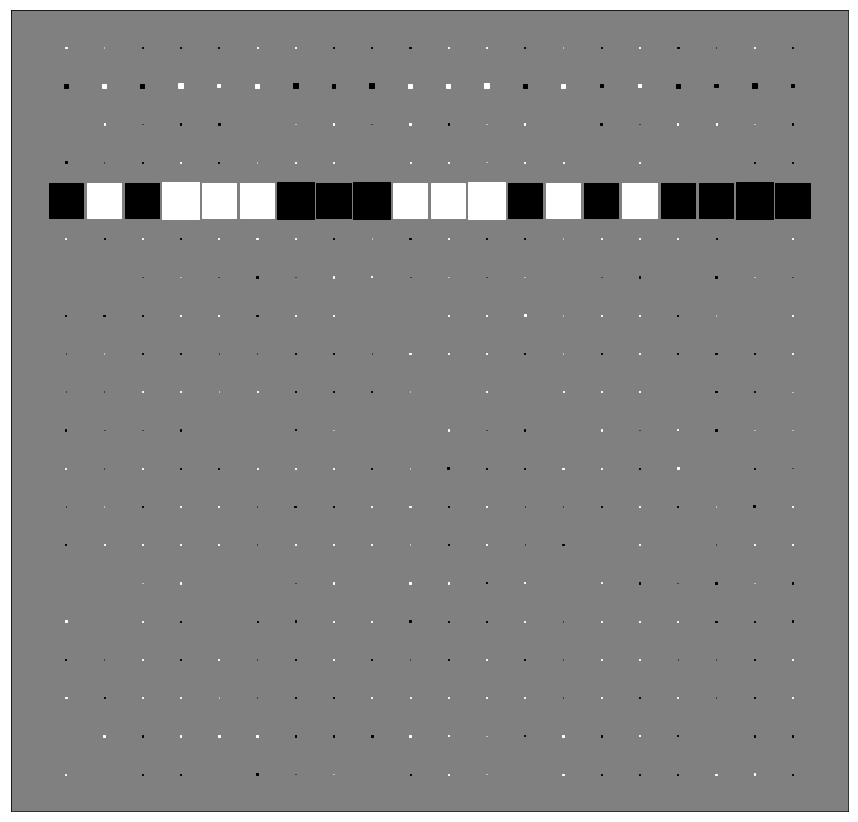

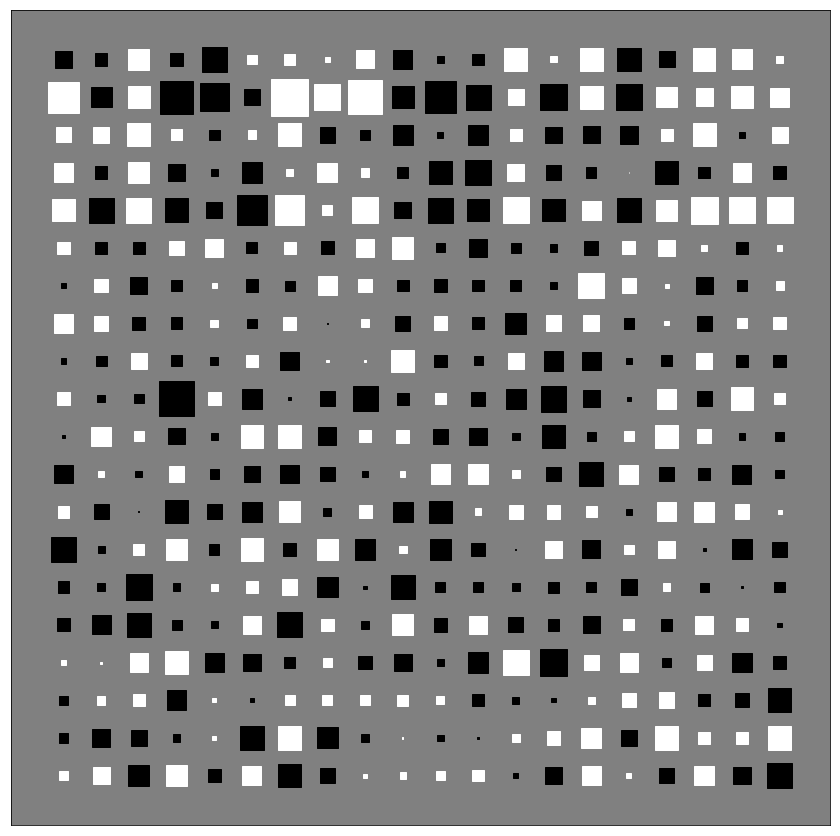

In [24]:
hinton(qwmode[0])
plt.show()
hinton(qwmode[1])

In [25]:
hinton(np.pad(w_true,((0,0),(0,D-K)), 'constant', constant_values=0.001))

NameError: name 'w_true' is not defined

In [ ]:
meddle.plot_histograms()

## W_hat

In [ ]:
w_hat = meddle.Qmodel[3].mean().eval()
hinton(w_hat.T)
plt.show()

np.round(w_hat,1)

w_true

hinton(w_true.T)
plt.show()

## PCA solution:

In [ ]:
U,S,V = np.linalg.svd(x_train-x_train.mean(0))
#np.dot(V,np.diag(S))/np.sqrt(N-1)
whitened = np.sqrt(N-1)*U

In [ ]:
W_hat = np.dot(V,np.diag(S))/np.sqrt(N-1)

In [ ]:
white = np.random.normal(size=x_train.shape)

In [ ]:
tmp = np.dot(white,W_hat).T+x_train.mean(0)[:,np.newaxis]

In [ ]:
tmp.shape

In [ ]:
doublepairplot(x_train,tmp.T)

In [ ]:
pairplot(white)

In [ ]:
qsigma.get_variables()[0].eval()

sorted(np.exp(qsigma.get_variables()[0].eval()))

tmp = qw.mean().eval()

tmp[abs(tmp)>0.05]

sigma

In [ ]:
alphas=tf.exp(qalpha.distribution.mean()).eval()
alphas.sort()
plt.plot(range(alphas.size),alphas)
plt.show()

In [ ]:
plt.hist(qalpha.sample(1000).eval(),bins=20)
plt.xlim(0,2)
plt.show()

In [ ]:
qsigma.get_variables()[0].eval()

In [ ]:
x_train.shape

In [ ]:
x_sim_sample = x_sim.sample().eval()

In [ ]:
x_sim_sample

In [ ]:
x_sim_sample.shape

In [ ]:
D

In [ ]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
tpm = qtmp.sample(10000).eval()

plt.hist(tpm[:,0],'auto',normed=True)
plt.axis([0,50,0,1])
plt.show()
plt.hist(np.log(tpm[:,0]),'auto',normed=True)
plt.show()

In [ ]:
x_train.shape